<h4>
<ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">OBJECTIVE:</span></strong></li>
</ul>
<p><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Use the text data to build a deep-learning based binary classifier.</span></p>
    </h4>

In [1]:
# imports

import warnings
warnings.filterwarnings('ignore')

import os
import math
import random
from time import time
from pathlib import Path
import pandas as pd, numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import defaultdict, Counter
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud, STOPWORDS
import tensorflow

tqdm.pandas()
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [2]:
# reproducibility
seed = 7
random.seed(seed)
tensorflow.random.set_seed(seed)

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Import the clean data.</span></strong></li>
</ul></h3>

In [3]:
dataset = pd.read_excel('./data/preprocessed_data.xlsx')
dataset.sample(5)

,translated_description,keywords,short_description,description,group,cleaned_description,cleaned_short_description,merged_description,char_length,word_length,short_char_length,short_word_length,language,language_confidence
3906,able log vpn try open new session go session f...,session go session finish page,i am not able to log into my vpn. when i am tr...,name:mehrugshy\nlanguage:\nbrowser:microsoft i...,GRP_0,able log vpn try open new session go session f...,able log vpn try open new session go session f...,able log vpn try open new session go session f...,254,37,120,28,en,0.644429
583,able logon crm website link user ottyhddok tel...,logon crm website link user,"hi, few users are not able to logon to crm web...",link : \nusers:\nottyhddok\nthielpwii2e\nlobod...,GRP_33,link user ottyhddok telpwiie lobodeidd loksdkd...,user able logon crm website,able logon crm website link user ottyhddok tel...,90,13,51,11,en,0.626343
1360,job sid filesys fail job scheduler,sid filesys fail job scheduler,job SID_56filesys failed in job_scheduler at: ...,received from: monitoring_tool@company.com\n\n...,GRP_5,job sid filesys fail job scheduler,job sid filesys fail job scheduler,job sid filesys fail job scheduler,109,11,67,8,en,0.629173
1725,user unable open reporting tool,user unable open reporting tool,user was unable to open reporting_tool,user was unable to open reporting_tool,GRP_0,user unable open reporting tool,user unable open reporting tool,user unable open reporting tool,38,6,38,6,en,0.964643
1884,automatic registration when I call the compute...,platform that is to register,automatische anmeldung,"wenn ich outlook aufrufe, will der rechner gle...",GRP_0,wenn ich outlook aufrufe der rechner gleichzei...,automatische anmeldung,automatische anmeldung wenn ich outlook aufruf...,334,47,22,2,de,0.997998


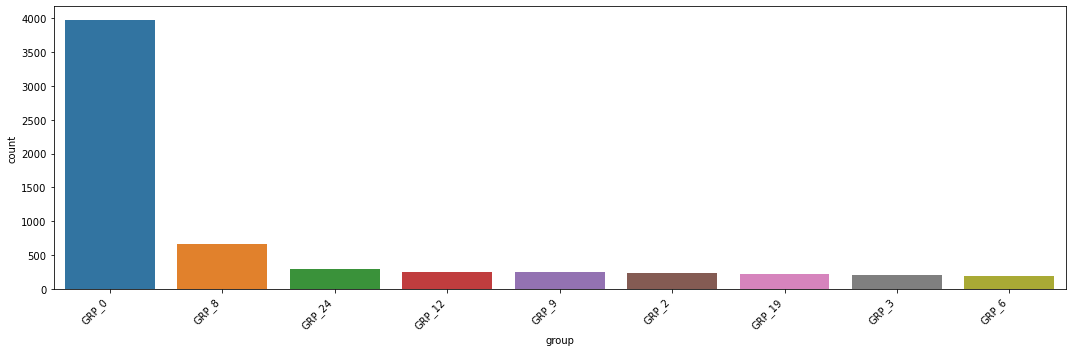

In [4]:
descending_order = dataset['group'].value_counts().sort_values(ascending=False).head(9).index
plt.subplots(figsize=(15,5))
ax=sns.countplot(x='group', data=dataset,order=descending_order)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [5]:
def group_clustering(top_frequency_groups):
    descending_order = dataset['group'].value_counts().sort_values(ascending=False).head(top_frequency_groups)
    Cluster_1=[]
    Cluster_2=[]
    Cluster_1.extend(list(descending_order.index))
    Cluster_2.extend(list(set(dataset['group'].unique())-set(descending_order.index)))
    return Cluster_1,Cluster_2

# the value of top_frequency_groups=9 turns out to be best fit
L12,L3=group_clustering(top_frequency_groups=9)
print('L12')
pprint(L12, compact=True)

print('\nL3')
pprint(L3, compact=True)

L12
['GRP_0', 'GRP_8', 'GRP_24', 'GRP_12', 'GRP_9', 'GRP_2', 'GRP_19', 'GRP_3',
 'GRP_6']

L3
['GRP_53', 'GRP_35', 'GRP_37', 'GRP_58', 'GRP_73', 'GRP_25', 'GRP_23', 'GRP_42',
 'GRP_36', 'GRP_59', 'GRP_71', 'GRP_52', 'GRP_29', 'GRP_27', 'GRP_33', 'GRP_10',
 'GRP_20', 'GRP_43', 'GRP_31', 'GRP_44', 'GRP_55', 'GRP_68', 'GRP_15', 'GRP_63',
 'GRP_18', 'GRP_65', 'GRP_11', 'GRP_32', 'GRP_5', 'GRP_69', 'GRP_26', 'GRP_1',
 'GRP_62', 'GRP_70', 'GRP_46', 'GRP_13', 'GRP_39', 'GRP_49', 'GRP_22', 'GRP_60',
 'GRP_30', 'GRP_40', 'GRP_72', 'GRP_51', 'GRP_34', 'GRP_17', 'GRP_48', 'GRP_50',
 'GRP_57', 'GRP_38', 'GRP_45', 'GRP_61', 'GRP_16', 'GRP_41', 'GRP_54', 'GRP_14',
 'GRP_67', 'GRP_47', 'GRP_21', 'GRP_66', 'GRP_4', 'GRP_28', 'GRP_7', 'GRP_56',
 'GRP_64']


In [6]:
def get_label(row):
    if row.group in L12:
        label = 0
    if row.group in L3:
        label = 1
    row['label'] = label
    return row

dataset = dataset.progress_apply(get_label, axis=1)

100%|█████████████████████████████████████████████████████████████████████████| 8499/8499 [00:04<00:00, 1999.77it/s]


In [7]:
dataset.label.value_counts()

0    5985
1    2514
Name: label, dtype: int64

In [71]:
dataset.to_csv('./data/preprocessed_data_groups.csv', index=None)

In [8]:
X = np.array(dataset.translated_description)
y = np.array(dataset.label)
X.shape, y.shape

((8499,), (8499,))

In [9]:
from tensorflow.keras.utils import to_categorical
y_dummy_coded = to_categorical(y)
y[0], y_dummy_coded[0]

(0, array([1., 0.], dtype=float32))

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_dummy_coded, test_size=.15,
                                                    random_state=seed, stratify=y_dummy_coded)  # splits are stratified by y

In [11]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7224,), (1275,), (7224, 2), (1275, 2))

In [12]:
X_train[0], y_train[0]  # check sample

('security suspicious netbios system name hostname santiagosouth amerirtca backup exec server user uidgt olibercsu olvidley location sep sms status see field sale dsw event log content versions fmxcnwpu tcwrdqboinition versionr sequence host integrity available reputation settingsr ap portal listr intrusion prevention signaturer power eraser definitionsr revocation contentr engine sonar extend file attribute signaturesr symantec permit application inent overview detect leastoccurrence firewall companyinternalasa company comdroppe traffic source hostname destine portof one destination device ts activity may indicate follow infection misconfigure port scan authorize unauthorized escalate via gh priority ticket phone call per default handling procedure would like we handle inent differently future option question concern let know either correspond delegate back soc call escalation alert block explicit notification medium automatically resolve reporting purpose sincerely dell securework te

In [13]:
# TODO: Check the distributions of groups in training and testing sets, i.e, if they vary too much
# stratify by y if required during splits
# or data augmentation to upsample minority classes to balance the group distributions

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Tokenize and pad sequences</span></strong></li>
</ul></h3>

In [14]:
# define params
NUM_WORDS = 20000
EMBEDDING_DIM = 300
MAX_LEN = 100 # dataset['word_length'].max()
MAX_LEN

100

In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


tokenizer = Tokenizer(num_words=NUM_WORDS)
tokenizer.fit_on_texts(X_train)
X_train_tokens = tokenizer.texts_to_sequences(X_train)
X_test_tokens = tokenizer.texts_to_sequences(X_test)
X_train_tokens[0], X_test_tokens[0]

([271,
  1136,
  1137,
  21,
  34,
  25,
  3281,
  511,
  33,
  2658,
  37,
  4,
  2278,
  3282,
  3283,
  147,
  370,
  1076,
  186,
  32,
  280,
  81,
  446,
  87,
  51,
  384,
  2659,
  2279,
  2280,
  2660,
  2281,
  218,
  2661,
  122,
  2662,
  2663,
  259,
  159,
  2664,
  2665,
  2666,
  2667,
  54,
  2668,
  2669,
  2670,
  2671,
  1138,
  2672,
  616,
  67,
  1823,
  2673,
  1139,
  1824,
  111,
  223,
  810,
  632,
  1528,
  730,
  2282,
  9,
  2283,
  371,
  263,
  25,
  1248,
  2284,
  117,
  372,
  61,
  3,
  436,
  206,
  335,
  88,
  871,
  2285,
  294,
  304,
  512,
  1140,
  676,
  156,
  274,
  247,
  17,
  73,
  45,
  213,
  350,
  731,
  437,
  131,
  173,
  105,
  351,
  223,
  651,
  500,
  291,
  277,
  545,
  152,
  128,
  438,
  625,
  571,
  140,
  601,
  45,
  602,
  192,
  190,
  471,
  174,
  250,
  378,
  91,
  385,
  546,
  492,
  352,
  1249,
  561,
  89,
  1825,
  1077,
  732,
  783,
  24,
  294,
  2286,
  1035,
  329,
  513,
  1826,
  732,
  1529,
  1

In [16]:
y_train[0], y_test[0]

(array([1., 0.], dtype=float32), array([0., 1.], dtype=float32))

In [17]:
# pad sequences to cut longer texts to a uniform length and pad the sentences that are shorter than that with <PAD> token

# using just 20 words from each headline will severely limit the information that is 
# available to the model and affect performance although the training will be faster
X_train_padded = pad_sequences(X_train_tokens,
                               padding='post',
                               truncating='post',
                               maxlen=MAX_LEN)
X_test_padded = pad_sequences(X_test_tokens,
                              padding='post',
                              truncating='post',
                              maxlen=MAX_LEN)


print(f'X train:  {X_train_padded.shape}\nX test:   {X_test_padded.shape}')

X train:  (7224, 100)
X test:   (1275, 100)


In [18]:
pprint(X_train_padded[0], compact=True)

array([ 271, 1136, 1137,   21,   34,   25, 3281,  511,   33, 2658,   37,
          4, 2278, 3282, 3283,  147,  370, 1076,  186,   32,  280,   81,
        446,   87,   51,  384, 2659, 2279, 2280, 2660, 2281,  218, 2661,
        122, 2662, 2663,  259,  159, 2664, 2665, 2666, 2667,   54, 2668,
       2669, 2670, 2671, 1138, 2672,  616,   67, 1823, 2673, 1139, 1824,
        111,  223,  810,  632, 1528,  730, 2282,    9, 2283,  371,  263,
         25, 1248, 2284,  117,  372,   61,    3,  436,  206,  335,   88,
        871, 2285,  294,  304,  512, 1140,  676,  156,  274,  247,   17,
         73,   45,  213,  350,  731,  437,  131,  173,  105,  351,  223,
        651])


In [19]:
WORD_TO_INDEX = tokenizer.word_index
# pprint(WORD_TO_INDEX, compact=True)
pprint(list(WORD_TO_INDEX.keys())[:100], compact=True)

['job', 'password', 'ts', 'user', 'erp', 'tool', 'issue', 'reset', 'company',
 'sid', 'scheduler', 'fail', 'access', 'error', 'work', 'unable', 'ticket', 'u',
 'account', 'need', 'system', 'help', 'get', 'use', 'hostname', 'site', 'login',
 'outlook', 'email', 'message', 'the', 'see', 'backup', 'name', 'update',
 'change', 'server', 'check', 'circuit', 'try', 'able', 'type', 'request',
 'printer', 'call', 'network', 'time', 'new', 'contact', 'order', 'log', 'usa',
 'problem', 'power', 'open', 'connect', 'lock', 'team', 'report', 'since',
 'device', 'plant', 't', 'engineering', 'vpn', 'pc', 'file', 'create',
 'maintenance', 'send', 'attach', 'window', 'phone', 'schedule', 'crm', 'print',
 'telecomvendor', 'skype', 'show', 'management', 'sale', 'start', 'connection',
 'vendor', 'receive', 'computer', 'event', 'follow', 'detail', 'number',
 'resolve', 'could', 'na', 'platform', 'production', 'information', 'with',
 'pm', 'unlock', 'collaboration']


In [20]:
VOCAB_SIZE = len(WORD_TO_INDEX) + 1
VOCAB_SIZE

9773

In [21]:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
def retrieve_description_feat(x, mapping=WORD_TO_INDEX) -> str:
    # increment 3 
    mapping = {k:(v + 3) for k, v in mapping.items()}
    mapping['<PAD>'] = 0
    mapping['<START>'] = 1
    mapping['<UNK>'] = 2
    inv_mapping = {v: k for k, v in mapping.items()}
    return str(" ".join(inv_mapping.get(i, '<NA>') for i in x))

retrieve_description_feat(X_test_padded[7])

'fail device ts print scheduler login monitor note power monday vvlahstyurr inform well note itypedport designate hash monitor account <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>'

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">GloVe Embeddings</span></strong></li>
</ul></h3>

In [22]:
EMBEDDING_DIM

300

In [23]:
def get_embedding_matrix(embedding_dim=EMBEDDING_DIM):
    embeddings = defaultdict()
    if embedding_dim == 200:
        file_path = f'./data/glove.6B.{embedding_dim}d.txt'
    elif embedding_dim == 300:
        file_path = f'./data/glove.840B.{embedding_dim}d.txt'
    for l in open(file_path, encoding='utf-8'):
        word = l.split(" ")[0]
        embeddings[word] = np.asarray(l.split(" ")[1:], dtype='float32')

    embeddings = dict(embeddings)

    # create a weight matrix for words in training docs
    embedding_matrix = np.zeros((NUM_WORDS, embedding_dim))

    for word, idx in WORD_TO_INDEX.items():
        embedding_vector = embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector

    return embedding_matrix

In [24]:
# use pre-trained glove embedding matrix to initialize weights in our model
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(20000, 300)

<h4><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Simple Feed-Forward Neural Net</span></strong></li>
</ul></h4>

In [25]:
# !pip install livelossplot
from tensorflow.python.keras.models import Sequential
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import max_norm, unit_norm
from tensorflow.python.keras.callbacks import LambdaCallback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Flatten, Dense, Activation, BatchNormalization, Dropout, Embedding, LSTM, MaxPooling1D, Conv1D, Bidirectional

In [26]:
NUM_CLASSES = 2
VOCAB_SIZE, MAX_LEN, EMBEDDING_DIM, NUM_CLASSES

(9773, 100, 300, 2)

In [27]:
# define model

model1 = Sequential([ 
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_LEN),
    Flatten(),
    Dense(1024, activation = 'relu'),
    Dense(1024, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(NUM_CLASSES, activation = 'softmax')
])

model1.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [28]:
# Define Callbacks and a few helper functions

# simplify the training log
simple_log = LambdaCallback(
    on_epoch_end = lambda e, l: print(f" ~| Epoch: {e+1} | Validation Loss: {l['val_loss']:.5f}", end =" >|> \n" ))

# early stopping
early_stop = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=7,
                              verbose=0, 
                              restore_best_weights=True)

# learning rate reduction
lr_reduce_on_plateau = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.4,
                                            min_lr=0.00001)

def plot_learning_curve(hist):
    sns.set()
    plt.figure(figsize=(5,5))
    train = hist.history['loss']
    val = hist.history['val_loss']
    epochs_run = range(1,len(train) + 1)
    sns.lineplot(epochs_run, train, marker = 'o', color = 'coral', label = 'Training Loss')
    sns.lineplot(epochs_run, val,  marker = '>', color = 'green', label = 'Validation Loss')
    plt.title("Loss vs. Epochs", fontsize = 20)
    plt.legend()
    plt.show()

In [29]:
X_train[0]

'security suspicious netbios system name hostname santiagosouth amerirtca backup exec server user uidgt olibercsu olvidley location sep sms status see field sale dsw event log content versions fmxcnwpu tcwrdqboinition versionr sequence host integrity available reputation settingsr ap portal listr intrusion prevention signaturer power eraser definitionsr revocation contentr engine sonar extend file attribute signaturesr symantec permit application inent overview detect leastoccurrence firewall companyinternalasa company comdroppe traffic source hostname destine portof one destination device ts activity may indicate follow infection misconfigure port scan authorize unauthorized escalate via gh priority ticket phone call per default handling procedure would like we handle inent differently future option question concern let know either correspond delegate back soc call escalation alert block explicit notification medium automatically resolve reporting purpose sincerely dell securework tec

In [30]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7224,), (7224, 2), (1275,), (1275, 2))

In [31]:
EPOCHS = 200
try:
    print("Training on GPU:")
    with tensorflow.device("gpu:0"):  # train on gpu
        h1 = model1.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop],
            verbose = False)
except Exception as e:
    print(e)
    print("\nTraining on CPU:")
    h1 = model1.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop],
            verbose = False)

print("\nTraining Done.")

Training on GPU:
 ~| Epoch: 1 | Validation Loss: 0.40762 >|> 
 ~| Epoch: 2 | Validation Loss: 0.45989 >|> 
 ~| Epoch: 3 | Validation Loss: 0.61361 >|> 
 ~| Epoch: 4 | Validation Loss: 0.79945 >|> 
 ~| Epoch: 5 | Validation Loss: 0.96624 >|> 
 ~| Epoch: 6 | Validation Loss: 0.99258 >|> 
 ~| Epoch: 7 | Validation Loss: 1.28460 >|> 
 ~| Epoch: 8 | Validation Loss: 0.98681 >|> 

Training Done.


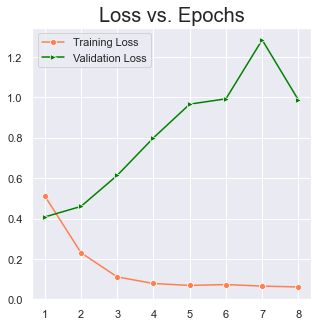

In [32]:
plot_learning_curve(h1)

In [33]:
loss, acc = model1.evaluate(X_test_padded, y_test)
print("Testing Loss: ", loss*100)
print("Testing Accuracy: ", acc*100)

40/40 [==============================] - 0s 3ms/step - loss: 0.4014 - accuracy: 0.8188
Testing Loss:  40.13861119747162
Testing Accuracy:  81.8823516368866


<h4><ul>
<span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">
    <li>This model is clearly overfitting, we will add regularization to the next iteration
 </span></ul></h4>

<h4><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Simple Feed-Forward Neural Net + Batch Normalization</span></strong></li>
</ul></h4>

In [34]:
# define model

model2 = Sequential([ 
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_LEN),
    Flatten(),
    Dense(256, activation = 'relu'),
    BatchNormalization(),
    Dense(256, activation = 'relu'),
    BatchNormalization(),
    Dense(NUM_CLASSES, activation = 'softmax')
])

model2.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [35]:
EPOCHS = 200
try:
    print("Training on GPU:")
    with tensorflow.device("gpu:0"):  # train on gpu
        h2 = model2.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop],
            verbose = False)
except Exception as e:
    print(e)
    print("Training on CPU:")
    h2 = model2.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop],
            verbose = False)

print("\nTraining Done.")

Training on GPU:
 ~| Epoch: 1 | Validation Loss: 0.88934 >|> 
 ~| Epoch: 2 | Validation Loss: 0.97065 >|> 
 ~| Epoch: 3 | Validation Loss: 0.52188 >|> 
 ~| Epoch: 4 | Validation Loss: 0.72759 >|> 
 ~| Epoch: 5 | Validation Loss: 0.54716 >|> 
 ~| Epoch: 6 | Validation Loss: 0.75639 >|> 
 ~| Epoch: 7 | Validation Loss: 0.73306 >|> 
 ~| Epoch: 8 | Validation Loss: 0.76720 >|> 
 ~| Epoch: 9 | Validation Loss: 0.91155 >|> 
 ~| Epoch: 10 | Validation Loss: 0.58389 >|> 

Training Done.


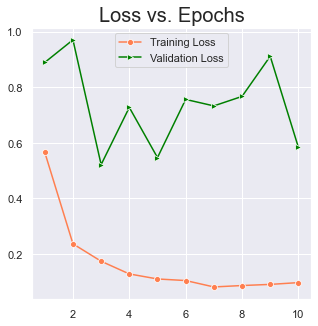

In [36]:
plot_learning_curve(h2)

In [37]:
loss, acc = model2.evaluate(X_test_padded, y_test)
print("Testing Loss: ", loss*100)
print("Testing Accuracy: ", acc*100)

40/40 [==============================] - 0s 3ms/step - loss: 0.5553 - accuracy: 0.7522
Testing Loss:  55.527979135513306
Testing Accuracy:  75.21568536758423


<h4><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Simple Feed-Forward Neural Net + Dropout</span></strong></li>
</ul></h4>

In [38]:
# define model

model3 = Sequential([ 
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_LEN),
    Flatten(),
    Dense(20, activation = 'relu'),
    Dropout(0.4),
    Dense(NUM_CLASSES, activation = 'softmax')
])

model3.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [39]:
EPOCHS = 200
try:
    print("Training on GPU:")
    with tensorflow.device("gpu:0"):  # train on gpu
        h3 = model3.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop, lr_reduce_on_plateau],
            verbose = False)
except Exception as e:
    print(e)
    print("Training on CPU:")
    h3 = model3.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop, lr_reduce_on_plateau],
            verbose = False)

print("\nTraining Done.")

Training on GPU:
 ~| Epoch: 1 | Validation Loss: 0.44251 >|> 
 ~| Epoch: 2 | Validation Loss: 0.43471 >|> 
 ~| Epoch: 3 | Validation Loss: 0.49978 >|> 
 ~| Epoch: 4 | Validation Loss: 0.60682 >|> 
 ~| Epoch: 5 | Validation Loss: 0.68696 >|> 
 ~| Epoch: 6 | Validation Loss: 0.74946 >|> 

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
 ~| Epoch: 7 | Validation Loss: 0.81176 >|> 
 ~| Epoch: 8 | Validation Loss: 0.81727 >|> 
 ~| Epoch: 9 | Validation Loss: 0.82799 >|> 

Training Done.


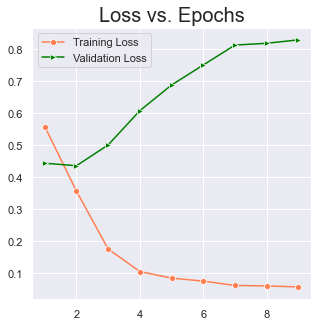

In [40]:
plot_learning_curve(h3)

In [41]:
loss, acc = model3.evaluate(X_test_padded, y_test)
print("Testing Accuracy: ", acc*100)

40/40 [==============================] - 0s 3ms/step - loss: 0.4295 - accuracy: 0.8094
Testing Accuracy:  80.94117641448975


<h4><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Use pre-trained embeddings</span></strong></li>
</ul></h4>

In [42]:
# define model

model3 = Sequential([ 
    Embedding(input_dim=NUM_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_LEN, weights=[embedding_matrix], trainable=True),
    Flatten(),
    Dense(30, activation = 'relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation = 'softmax')
])

model3.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'rmsprop',
    metrics = ['accuracy']
)

In [43]:
EPOCHS = 200
try:
    print("Training on GPU:")
    with tensorflow.device("gpu:0"):  # train on gpu
        h3 = model3.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop],
            verbose = False)
except Exception as e:
    print(e)
    print("Training on CPU:")
    h3 = model3.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop],
            verbose = False)

print("\nTraining Done.")

Training on GPU:
 ~| Epoch: 1 | Validation Loss: 0.45669 >|> 
 ~| Epoch: 2 | Validation Loss: 0.46318 >|> 
 ~| Epoch: 3 | Validation Loss: 0.47607 >|> 
 ~| Epoch: 4 | Validation Loss: 0.51958 >|> 
 ~| Epoch: 5 | Validation Loss: 0.55230 >|> 
 ~| Epoch: 6 | Validation Loss: 0.64084 >|> 
 ~| Epoch: 7 | Validation Loss: 0.73939 >|> 
 ~| Epoch: 8 | Validation Loss: 0.82803 >|> 

Training Done.


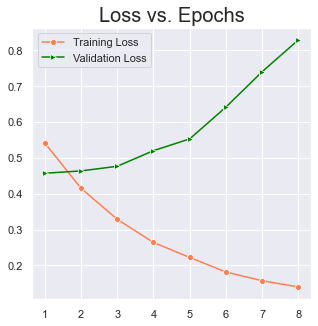

In [44]:
plot_learning_curve(h3)

In [45]:
loss, acc = model3.evaluate(X_test_padded, y_test)
print("Testing Accuracy: ", acc*100)

40/40 [==============================] - 0s 3ms/step - loss: 0.4526 - accuracy: 0.7804
Testing Accuracy:  78.03921699523926


<h4><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">LSTM</span></strong></li>
</ul></h4>

In [46]:
# define model

model4 = Sequential([ 
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_LEN),
    LSTM(32),
    Dropout(0.4),
    Dense(NUM_CLASSES, activation = 'softmax')
])

model4.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [47]:
EPOCHS = 50
try:
    print("Training on GPU:")
    with tensorflow.device("gpu:0"):  # train on gpu
        h4 = model4.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, lr_reduce_on_plateau],
            verbose = False)
except Exception as e:
    print(e)
    print("Training on CPU:")
    h4 = model4.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, lr_reduce_on_plateau],
            verbose = False)

print("\nTraining Done.")

Training on GPU:
 ~| Epoch: 1 | Validation Loss: 0.59684 >|> 
 ~| Epoch: 2 | Validation Loss: 0.60537 >|> 
 ~| Epoch: 3 | Validation Loss: 0.59950 >|> 
 ~| Epoch: 4 | Validation Loss: 0.60150 >|> 
 ~| Epoch: 5 | Validation Loss: 0.60247 >|> 

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
 ~| Epoch: 6 | Validation Loss: 0.60493 >|> 
 ~| Epoch: 7 | Validation Loss: 0.60554 >|> 
 ~| Epoch: 8 | Validation Loss: 0.60608 >|> 
 ~| Epoch: 9 | Validation Loss: 0.60846 >|> 

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.00016000000759959222.
 ~| Epoch: 10 | Validation Loss: 0.61022 >|> 
 ~| Epoch: 11 | Validation Loss: 0.61205 >|> 
 ~| Epoch: 12 | Validation Loss: 0.61601 >|> 
 ~| Epoch: 13 | Validation Loss: 0.61596 >|> 

Epoch 00013: ReduceLROnPlateau reducing learning rate to 6.40000042039901e-05.
 ~| Epoch: 14 | Validation Loss: 0.61936 >|> 
 ~| Epoch: 15 | Validation Loss: 0.61700 >|> 
 ~| Epoch: 16 | Validation Loss: 0.61830 >|> 
 ~| Epoch: 17

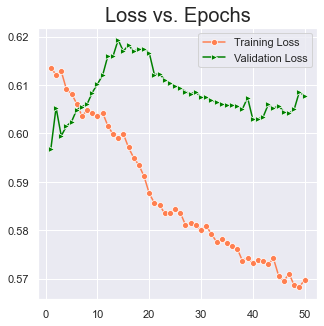

In [48]:
plot_learning_curve(h4)

In [49]:
loss, acc = model4.evaluate(X_test_padded, y_test)
print("Testing Accuracy: ", acc*100)

40/40 [==============================] - 0s 6ms/step - loss: 0.5941 - accuracy: 0.7271
Testing Accuracy:  72.70588278770447


<h4><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Bi-Directional LSTM</span></strong></li>
</ul></h4>

In [50]:
# define model

model4 = Sequential([ 
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_LEN),
    Bidirectional(LSTM(32)),
    Dropout(0.4),
    Dense(NUM_CLASSES, activation = 'softmax')
])

model4.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'rmsprop',
    metrics = ['accuracy']
)

In [51]:
EPOCHS = 200
try:
    print("Training on GPU:")
    with tensorflow.device("gpu:0"):  # train on gpu
        h4 = model4.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop, lr_reduce_on_plateau],
            verbose = False)
except Exception as e:
    print(e)
    print("Training on CPU:")
    h4 = model4.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop, lr_reduce_on_plateau],
            verbose = False)

print("\nTraining Done.")

Training on GPU:
 ~| Epoch: 1 | Validation Loss: 0.44402 >|> 
 ~| Epoch: 2 | Validation Loss: 0.41793 >|> 
 ~| Epoch: 3 | Validation Loss: 0.42399 >|> 
 ~| Epoch: 4 | Validation Loss: 0.47163 >|> 
 ~| Epoch: 5 | Validation Loss: 0.47986 >|> 
 ~| Epoch: 6 | Validation Loss: 0.49628 >|> 

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
 ~| Epoch: 7 | Validation Loss: 0.55975 >|> 
 ~| Epoch: 8 | Validation Loss: 0.59101 >|> 
 ~| Epoch: 9 | Validation Loss: 0.59970 >|> 

Training Done.


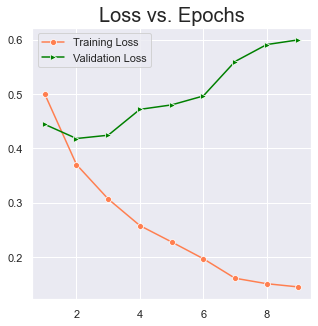

In [52]:
plot_learning_curve(h4)

In [53]:
loss, acc = model4.evaluate(X_test_padded, y_test)
print("Testing Accuracy: ", acc*100)

40/40 [==============================] - 0s 8ms/step - loss: 0.4302 - accuracy: 0.8118
Testing Accuracy:  81.17647171020508


<h4><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">CNN (Dimensionality Reduction) + LSTM</span></strong></li>
</ul></h4>

In [54]:
model5 = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=256, input_length=MAX_LEN),
    Dropout(0.25),
    Conv1D(256, 5, padding = 'same', activation = 'relu', strides = 1),
    Conv1D(256, 5, padding = 'same', activation = 'relu', strides = 1),
    MaxPooling1D(pool_size = 2),
    Conv1D(64, 5, padding = 'same', activation = 'relu', strides = 1),
    MaxPooling1D(pool_size = 2),
    LSTM(75),
    Dense(NUM_CLASSES, activation = 'softmax')
])

model5.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [55]:
EPOCHS = 20
try:
    print("Training on GPU:")
    with tensorflow.device("gpu:0"):  # train on gpu
        h5 = model5.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop, lr_reduce_on_plateau],
            verbose = False)
except Exception as e:
    print(e)
    print("Training on CPU:")
    h5 = model5.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop, lr_reduce_on_plateau],
            verbose = False)

print("\nTraining Done.")

Training on GPU:
 ~| Epoch: 1 | Validation Loss: 0.50571 >|> 
 ~| Epoch: 2 | Validation Loss: 0.49394 >|> 
 ~| Epoch: 3 | Validation Loss: 0.48575 >|> 
 ~| Epoch: 4 | Validation Loss: 0.49505 >|> 
 ~| Epoch: 5 | Validation Loss: 0.47481 >|> 
 ~| Epoch: 6 | Validation Loss: 0.54364 >|> 
 ~| Epoch: 7 | Validation Loss: 0.65160 >|> 
 ~| Epoch: 8 | Validation Loss: 0.60695 >|> 
 ~| Epoch: 9 | Validation Loss: 0.61398 >|> 

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
 ~| Epoch: 10 | Validation Loss: 0.74401 >|> 
 ~| Epoch: 11 | Validation Loss: 0.77433 >|> 
 ~| Epoch: 12 | Validation Loss: 0.82399 >|> 

Training Done.


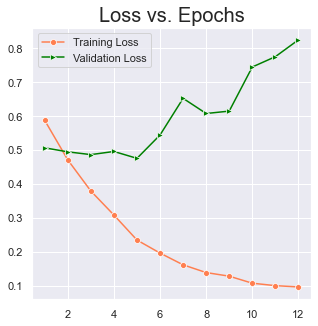

In [56]:
plot_learning_curve(h5)

In [57]:
loss, acc = model5.evaluate(X_test_padded, y_test)
print("Testing Accuracy: ", acc*100)

40/40 [==============================] - 0s 8ms/step - loss: 0.4902 - accuracy: 0.8086
Testing Accuracy:  80.86274266242981


<h4><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">CNN (Dimensionality Reduction) + Bi-Directional LSTM</span></strong></li>
</ul></h4>

In [58]:
model5 = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=256, input_length=MAX_LEN),
    Dropout(0.25),
    Conv1D(256, 5, padding = 'same', activation = 'relu', strides = 1),
    Conv1D(256, 5, padding = 'same', activation = 'relu', strides = 1),
    MaxPooling1D(pool_size = 2),
    Conv1D(64, 5, padding = 'same', activation = 'relu', strides = 1),
    MaxPooling1D(pool_size = 2),
    Bidirectional(LSTM(75, recurrent_dropout=0.5)),
    Dense(NUM_CLASSES, activation = 'softmax')
])

model5.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [59]:
EPOCHS = 20
try:
    print("Training on GPU:")
    with tensorflow.device("gpu:0"):  # train on gpu
        h5 = model5.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop],
            verbose = False)
except Exception as e:
    print(e)
    print("Training on CPU:")
    h5 = model5.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop],
            verbose = False)

print("\nTraining Done.")

Training on GPU:
 ~| Epoch: 1 | Validation Loss: 0.41348 >|> 
 ~| Epoch: 2 | Validation Loss: 0.43821 >|> 
 ~| Epoch: 3 | Validation Loss: 0.49128 >|> 
 ~| Epoch: 4 | Validation Loss: 0.63527 >|> 
 ~| Epoch: 5 | Validation Loss: 0.67690 >|> 
 ~| Epoch: 6 | Validation Loss: 0.78350 >|> 
 ~| Epoch: 7 | Validation Loss: 0.85579 >|> 
 ~| Epoch: 8 | Validation Loss: 0.90307 >|> 

Training Done.


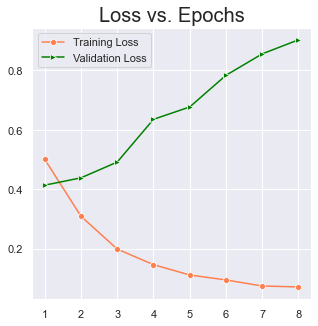

In [60]:
plot_learning_curve(h5)

In [61]:
loss, acc = model5.evaluate(X_test_padded, y_test)
print("Testing Accuracy: ", acc*100)

40/40 [==============================] - 3s 62ms/step - loss: 0.4126 - accuracy: 0.8267
Testing Accuracy:  82.66666531562805


<h4><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Use TfIdf vectors instead of Embedding Layer + Feature Selection</span></strong></li>
</ul></h4>

In [62]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# using 75-25 split instead of 50-50 split as we need more data to train neural nets
X_train_vec, X_test_vec, y_train_vec, y_test_vec = train_test_split(X, y, test_size=0.15, random_state=seed, stratify=y)
print(f"Train dataset shape: {X_train_vec.shape}, \nTest dataset shape: {X_test_vec.shape}")

Train dataset shape: (7224,), 
Test dataset shape: (1275,)


In [63]:
NGRAM_RANGE = (1, 3)
TOP_K = 8500
TOKEN_MODE = 'word'
MIN_DOC_FREQ = 2


kwargs = {
    'ngram_range' : NGRAM_RANGE,
    'dtype' : 'int32',
    'strip_accents' : 'unicode',
    'decode_error' : 'replace',
    'analyzer' : TOKEN_MODE,
    'min_df' : MIN_DOC_FREQ
}
vectorizer = TfidfVectorizer(**kwargs)
X_train_vec = vectorizer.fit_transform(X_train_vec)
X_test_vec = vectorizer.transform(X_test_vec)
print(f"Train dataset shape: {X_train_vec.shape}, \nTest dataset shape: {X_test_vec.shape}")

Train dataset shape: (7224, 21387), 
Test dataset shape: (1275, 21387)


In [64]:
from sklearn.feature_selection import SelectKBest, f_classif

# Select best k features, with feature importance measured by f_classif
# Set k as 20000 or (if number of ngrams is less) number of ngrams   
selector = SelectKBest(f_classif, k=min(TOP_K, X_train_vec.shape[1]))
selector.fit(X_train_vec, y_train_vec)
X_train_vec = selector.transform(X_train_vec).astype('float32')
X_test_vec = selector.transform(X_test_vec).astype('float32')
X_train_vec = X_train_vec.toarray()
X_test_vec = X_test_vec.toarray()

print(f"Train dataset shape: {X_train_vec.shape}, \nTest dataset shape: {X_test_vec.shape}")

Train dataset shape: (7224, 8500), 
Test dataset shape: (1275, 8500)


In [65]:
model6 = Sequential([
    Dense(30, activation='relu', input_shape=X_train_vec.shape[1:]),
    Dropout(0.5),
    Dense(20, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model6.compile(
    loss = 'binary_crossentropy',
    optimizer = 'rmsprop',
    metrics = ['accuracy']
)

In [66]:
EPOCHS = 20
try:
    print("Training on GPU:")
    with tensorflow.device("gpu:0"):  # train on gpu
        h6 = model6.fit(
            X_train_vec, y_train_vec,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop],
            verbose = False)
except Exception:
    print("Training on CPU:")
    h6 = model6.fit(
            X_train_vec, y_train_vec,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop],
            verbose = False)

print("\nTraining Done.")

Training on GPU:
 ~| Epoch: 1 | Validation Loss: 0.58316 >|> 
 ~| Epoch: 2 | Validation Loss: 0.51843 >|> 
 ~| Epoch: 3 | Validation Loss: 0.46900 >|> 
 ~| Epoch: 4 | Validation Loss: 0.44677 >|> 
 ~| Epoch: 5 | Validation Loss: 0.42376 >|> 
 ~| Epoch: 6 | Validation Loss: 0.40904 >|> 
 ~| Epoch: 7 | Validation Loss: 0.40370 >|> 
 ~| Epoch: 8 | Validation Loss: 0.40825 >|> 
 ~| Epoch: 9 | Validation Loss: 0.41006 >|> 
 ~| Epoch: 10 | Validation Loss: 0.42390 >|> 
 ~| Epoch: 11 | Validation Loss: 0.42738 >|> 
 ~| Epoch: 12 | Validation Loss: 0.43645 >|> 
 ~| Epoch: 13 | Validation Loss: 0.43908 >|> 
 ~| Epoch: 14 | Validation Loss: 0.44948 >|> 

Training Done.


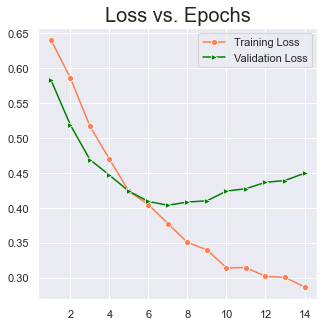

In [67]:
plot_learning_curve(h6)

In [68]:
loss, acc = model6.evaluate(X_test_vec, y_test_vec)
print("Testing Accuracy: ", acc*100)

40/40 [==============================] - 0s 3ms/step - loss: 0.3950 - accuracy: 0.8298
Testing Accuracy:  82.98039436340332


<h4><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Use TfIdf vectors instead of Embedding Layer + Feature Selection + Stratified KFold Training</span></strong></li>
</ul></h4>


Train dataset shape: (8159, 17004), 
Test dataset shape: (340, 17004)

Features Train dataset shape: (8159, 15000), 
FeaturesTest dataset shape: (340, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.70588, saving model to models\binary_classfiier\dl\merged_descr\model_1.h5

Epoch 00002: val_accuracy did not improve from 0.70588

Epoch 00003: val_accuracy improved from 0.70588 to 0.86471, saving model to models\binary_classfiier\dl\merged_descr\model_1.h5

Epoch 00004: val_accuracy did not improve from 0.86471

Epoch 00005: val_accuracy did not improve from 0.86471

Epoch 00006: val_accuracy did not improve from 0.86471

Epoch 00007: val_accuracy did not improve from 0.86471

Epoch 00008: val_accuracy did not improve from 0.86471

Epoch 00009: val_accuracy did not improve from 0.86471

Epoch 00010: val_accuracy did not improve from 0.86471


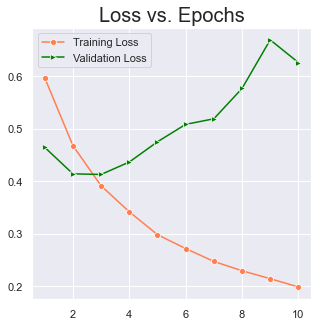

11/11 [==============================] - 0s 3ms/step - loss: 0.4127 - accuracy: 0.8647
Testing Accuracy:  86.47058606147766

Train dataset shape: (8159, 16951), 
Test dataset shape: (340, 16951)

Features Train dataset shape: (8159, 15000), 
FeaturesTest dataset shape: (340, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.70588, saving model to models\binary_classfiier\dl\merged_descr\model_2.h5

Epoch 00002: val_accuracy did not improve from 0.70588

Epoch 00003: val_accuracy improved from 0.70588 to 0.82059, saving model to models\binary_classfiier\dl\merged_descr\model_2.h5

Epoch 00004: val_accuracy did not improve from 0.82059

Epoch 00005: val_accuracy did not improve from 0.82059

Epoch 00006: val_accuracy did not improve from 0.82059

Epoch 00007: val_accuracy did not improve from 0.82059

Epoch 00008: val_accuracy did not improve from 0.82059

Epoch 00009: val_accuracy did not improve from 0.82059


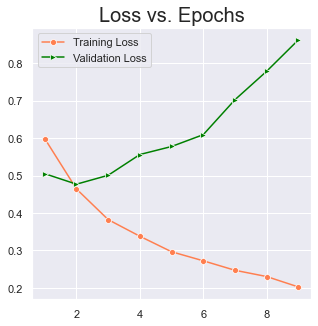

11/11 [==============================] - 0s 3ms/step - loss: 0.5007 - accuracy: 0.8206
Testing Accuracy:  82.0588231086731

Train dataset shape: (8159, 16906), 
Test dataset shape: (340, 16906)

Features Train dataset shape: (8159, 15000), 
FeaturesTest dataset shape: (340, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.70588, saving model to models\binary_classfiier\dl\merged_descr\model_3.h5

Epoch 00002: val_accuracy improved from 0.70588 to 0.83235, saving model to models\binary_classfiier\dl\merged_descr\model_3.h5

Epoch 00003: val_accuracy did not improve from 0.83235

Epoch 00004: val_accuracy did not improve from 0.83235

Epoch 00005: val_accuracy improved from 0.83235 to 0.83529, saving model to models\binary_classfiier\dl\merged_descr\model_3.h5

Epoch 00006: val_accuracy did not improve from 0.83529

Epoch 00007: val_accuracy did not improve from 0.83529

Epoch 00008: val_accuracy did not improve from 0.83529

Epoch 00009: val_accuracy did not improve from 0.8352

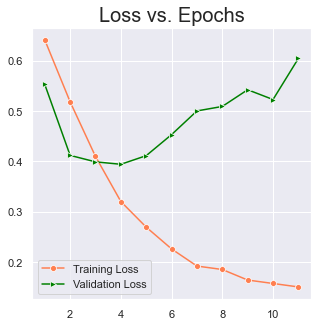

11/11 [==============================] - 0s 3ms/step - loss: 0.5226 - accuracy: 0.8441
Testing Accuracy:  84.41176414489746

Train dataset shape: (8159, 16862), 
Test dataset shape: (340, 16862)

Features Train dataset shape: (8159, 15000), 
FeaturesTest dataset shape: (340, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.70588, saving model to models\binary_classfiier\dl\merged_descr\model_4.h5

Epoch 00002: val_accuracy improved from 0.70588 to 0.82647, saving model to models\binary_classfiier\dl\merged_descr\model_4.h5

Epoch 00003: val_accuracy improved from 0.82647 to 0.83824, saving model to models\binary_classfiier\dl\merged_descr\model_4.h5

Epoch 00004: val_accuracy did not improve from 0.83824

Epoch 00005: val_accuracy did not improve from 0.83824

Epoch 00006: val_accuracy did not improve from 0.83824

Epoch 00007: val_accuracy did not improve from 0.83824

Epoch 00008: val_accuracy did not improve from 0.83824

Epoch 00009: val_accuracy did not improve from 0.838

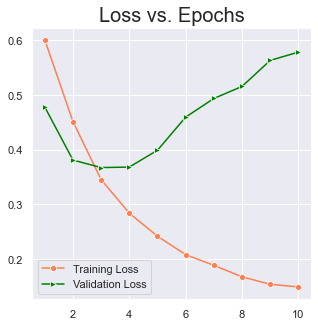

11/11 [==============================] - 0s 3ms/step - loss: 0.3674 - accuracy: 0.8382
Testing Accuracy:  83.82353186607361

Train dataset shape: (8159, 16977), 
Test dataset shape: (340, 16977)

Features Train dataset shape: (8159, 15000), 
FeaturesTest dataset shape: (340, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.70588, saving model to models\binary_classfiier\dl\merged_descr\model_5.h5

Epoch 00002: val_accuracy improved from 0.70588 to 0.86471, saving model to models\binary_classfiier\dl\merged_descr\model_5.h5

Epoch 00003: val_accuracy did not improve from 0.86471

Epoch 00004: val_accuracy did not improve from 0.86471

Epoch 00005: val_accuracy did not improve from 0.86471

Epoch 00006: val_accuracy did not improve from 0.86471

Epoch 00007: val_accuracy did not improve from 0.86471

Epoch 00008: val_accuracy did not improve from 0.86471

Epoch 00009: val_accuracy did not improve from 0.86471

Epoch 00010: val_accuracy did not improve from 0.86471


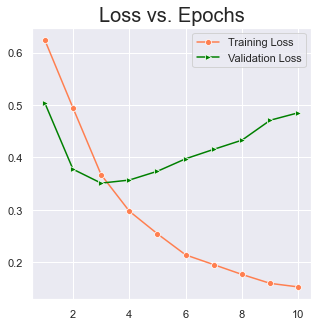

11/11 [==============================] - 0s 3ms/step - loss: 0.3777 - accuracy: 0.8647
Testing Accuracy:  86.47058606147766

Train dataset shape: (8159, 16916), 
Test dataset shape: (340, 16916)

Features Train dataset shape: (8159, 15000), 
FeaturesTest dataset shape: (340, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.70588, saving model to models\binary_classfiier\dl\merged_descr\model_6.h5

Epoch 00002: val_accuracy improved from 0.70588 to 0.83235, saving model to models\binary_classfiier\dl\merged_descr\model_6.h5

Epoch 00003: val_accuracy improved from 0.83235 to 0.83824, saving model to models\binary_classfiier\dl\merged_descr\model_6.h5

Epoch 00004: val_accuracy did not improve from 0.83824

Epoch 00005: val_accuracy did not improve from 0.83824

Epoch 00006: val_accuracy did not improve from 0.83824

Epoch 00007: val_accuracy did not improve from 0.83824

Epoch 00008: val_accuracy did not improve from 0.83824

Epoch 00009: val_accuracy did not improve from 0.838

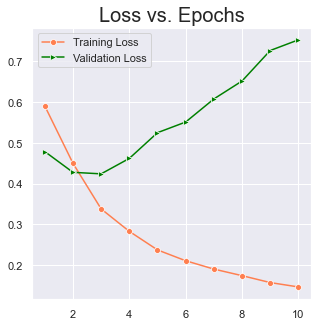

11/11 [==============================] - 0s 3ms/step - loss: 0.4238 - accuracy: 0.8382
Testing Accuracy:  83.82353186607361

Train dataset shape: (8159, 16988), 
Test dataset shape: (340, 16988)

Features Train dataset shape: (8159, 15000), 
FeaturesTest dataset shape: (340, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.70588, saving model to models\binary_classfiier\dl\merged_descr\model_7.h5

Epoch 00002: val_accuracy did not improve from 0.70588

Epoch 00003: val_accuracy improved from 0.70588 to 0.83529, saving model to models\binary_classfiier\dl\merged_descr\model_7.h5

Epoch 00004: val_accuracy did not improve from 0.83529

Epoch 00005: val_accuracy did not improve from 0.83529

Epoch 00006: val_accuracy did not improve from 0.83529

Epoch 00007: val_accuracy did not improve from 0.83529

Epoch 00008: val_accuracy did not improve from 0.83529

Epoch 00009: val_accuracy did not improve from 0.83529

Epoch 00010: val_accuracy did not improve from 0.83529


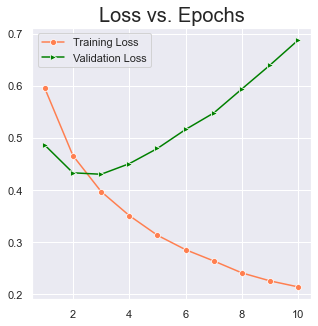

11/11 [==============================] - 0s 3ms/step - loss: 0.4300 - accuracy: 0.8353
Testing Accuracy:  83.52941274642944

Train dataset shape: (8159, 16924), 
Test dataset shape: (340, 16924)

Features Train dataset shape: (8159, 15000), 
FeaturesTest dataset shape: (340, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.70588, saving model to models\binary_classfiier\dl\merged_descr\model_8.h5

Epoch 00002: val_accuracy improved from 0.70588 to 0.84118, saving model to models\binary_classfiier\dl\merged_descr\model_8.h5

Epoch 00003: val_accuracy improved from 0.84118 to 0.84412, saving model to models\binary_classfiier\dl\merged_descr\model_8.h5

Epoch 00004: val_accuracy did not improve from 0.84412

Epoch 00005: val_accuracy did not improve from 0.84412

Epoch 00006: val_accuracy did not improve from 0.84412

Epoch 00007: val_accuracy did not improve from 0.84412

Epoch 00008: val_accuracy did not improve from 0.84412

Epoch 00009: val_accuracy did not improve from 0.844

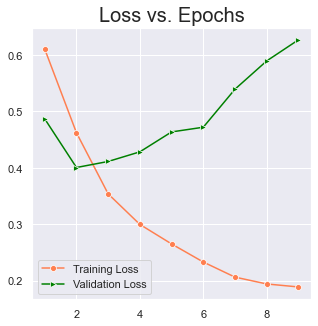

11/11 [==============================] - 0s 3ms/step - loss: 0.4113 - accuracy: 0.8441
Testing Accuracy:  84.41176414489746

Train dataset shape: (8159, 16685), 
Test dataset shape: (340, 16685)

Features Train dataset shape: (8159, 15000), 
FeaturesTest dataset shape: (340, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.70588, saving model to models\binary_classfiier\dl\merged_descr\model_9.h5

Epoch 00002: val_accuracy improved from 0.70588 to 0.82941, saving model to models\binary_classfiier\dl\merged_descr\model_9.h5

Epoch 00003: val_accuracy did not improve from 0.82941

Epoch 00004: val_accuracy did not improve from 0.82941

Epoch 00005: val_accuracy did not improve from 0.82941

Epoch 00006: val_accuracy did not improve from 0.82941

Epoch 00007: val_accuracy did not improve from 0.82941

Epoch 00008: val_accuracy did not improve from 0.82941

Epoch 00009: val_accuracy did not improve from 0.82941

Epoch 00010: val_accuracy did not improve from 0.82941


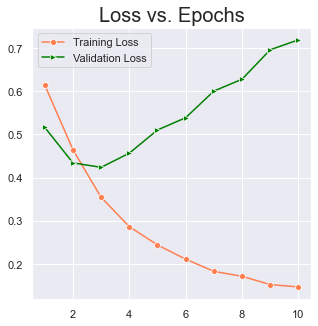

11/11 [==============================] - 0s 3ms/step - loss: 0.4340 - accuracy: 0.8294
Testing Accuracy:  82.94117450714111

Train dataset shape: (8159, 16848), 
Test dataset shape: (340, 16848)

Features Train dataset shape: (8159, 15000), 
FeaturesTest dataset shape: (340, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.71765, saving model to models\binary_classfiier\dl\merged_descr\model_10.h5

Epoch 00002: val_accuracy improved from 0.71765 to 0.80882, saving model to models\binary_classfiier\dl\merged_descr\model_10.h5

Epoch 00003: val_accuracy improved from 0.80882 to 0.81471, saving model to models\binary_classfiier\dl\merged_descr\model_10.h5

Epoch 00004: val_accuracy did not improve from 0.81471

Epoch 00005: val_accuracy did not improve from 0.81471

Epoch 00006: val_accuracy did not improve from 0.81471

Epoch 00007: val_accuracy did not improve from 0.81471

Epoch 00008: val_accuracy did not improve from 0.81471

Epoch 00009: val_accuracy did not improve from 0.

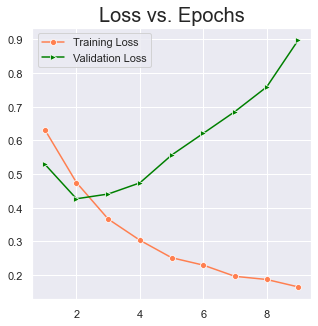

11/11 [==============================] - 0s 3ms/step - loss: 0.4409 - accuracy: 0.8147
Testing Accuracy:  81.47059082984924

Train dataset shape: (8159, 16714), 
Test dataset shape: (340, 16714)

Features Train dataset shape: (8159, 15000), 
FeaturesTest dataset shape: (340, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.70294, saving model to models\binary_classfiier\dl\merged_descr\model_11.h5

Epoch 00002: val_accuracy improved from 0.70294 to 0.82647, saving model to models\binary_classfiier\dl\merged_descr\model_11.h5

Epoch 00003: val_accuracy improved from 0.82647 to 0.82941, saving model to models\binary_classfiier\dl\merged_descr\model_11.h5

Epoch 00004: val_accuracy improved from 0.82941 to 0.84118, saving model to models\binary_classfiier\dl\merged_descr\model_11.h5

Epoch 00005: val_accuracy did not improve from 0.84118

Epoch 00006: val_accuracy did not improve from 0.84118

Epoch 00007: val_accuracy did not improve from 0.84118

Epoch 00008: val_accuracy did n

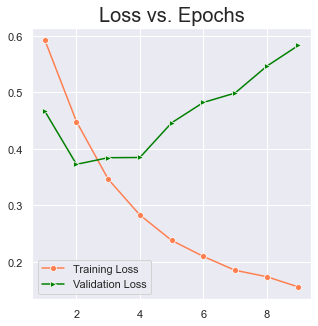

11/11 [==============================] - 0s 3ms/step - loss: 0.3848 - accuracy: 0.8412
Testing Accuracy:  84.1176450252533

Train dataset shape: (8159, 16552), 
Test dataset shape: (340, 16552)

Features Train dataset shape: (8159, 15000), 
FeaturesTest dataset shape: (340, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.70294, saving model to models\binary_classfiier\dl\merged_descr\model_12.h5

Epoch 00002: val_accuracy improved from 0.70294 to 0.80000, saving model to models\binary_classfiier\dl\merged_descr\model_12.h5

Epoch 00003: val_accuracy improved from 0.80000 to 0.80588, saving model to models\binary_classfiier\dl\merged_descr\model_12.h5

Epoch 00004: val_accuracy improved from 0.80588 to 0.81176, saving model to models\binary_classfiier\dl\merged_descr\model_12.h5

Epoch 00005: val_accuracy did not improve from 0.81176

Epoch 00006: val_accuracy did not improve from 0.81176

Epoch 00007: val_accuracy improved from 0.81176 to 0.81765, saving model to models\binar

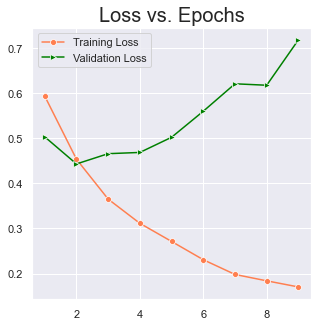

11/11 [==============================] - 0s 3ms/step - loss: 0.6211 - accuracy: 0.8176
Testing Accuracy:  81.76470398902893

Train dataset shape: (8159, 16581), 
Test dataset shape: (340, 16581)

Features Train dataset shape: (8159, 15000), 
FeaturesTest dataset shape: (340, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.70294, saving model to models\binary_classfiier\dl\merged_descr\model_13.h5

Epoch 00002: val_accuracy improved from 0.70294 to 0.83235, saving model to models\binary_classfiier\dl\merged_descr\model_13.h5

Epoch 00003: val_accuracy improved from 0.83235 to 0.83529, saving model to models\binary_classfiier\dl\merged_descr\model_13.h5

Epoch 00004: val_accuracy did not improve from 0.83529

Epoch 00005: val_accuracy did not improve from 0.83529

Epoch 00006: val_accuracy did not improve from 0.83529

Epoch 00007: val_accuracy did not improve from 0.83529

Epoch 00008: val_accuracy did not improve from 0.83529

Epoch 00009: val_accuracy did not improve from 0.

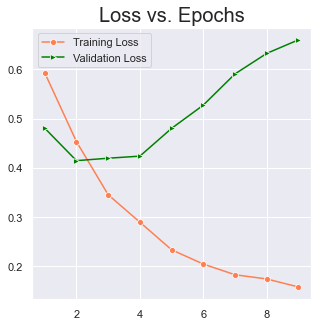

11/11 [==============================] - 0s 3ms/step - loss: 0.4193 - accuracy: 0.8353
Testing Accuracy:  83.52941274642944

Train dataset shape: (8159, 16837), 
Test dataset shape: (340, 16837)

Features Train dataset shape: (8159, 15000), 
FeaturesTest dataset shape: (340, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.70294, saving model to models\binary_classfiier\dl\merged_descr\model_14.h5

Epoch 00002: val_accuracy improved from 0.70294 to 0.84412, saving model to models\binary_classfiier\dl\merged_descr\model_14.h5

Epoch 00003: val_accuracy improved from 0.84412 to 0.85000, saving model to models\binary_classfiier\dl\merged_descr\model_14.h5

Epoch 00004: val_accuracy did not improve from 0.85000

Epoch 00005: val_accuracy did not improve from 0.85000

Epoch 00006: val_accuracy did not improve from 0.85000

Epoch 00007: val_accuracy did not improve from 0.85000

Epoch 00008: val_accuracy did not improve from 0.85000

Epoch 00009: val_accuracy did not improve from 0.

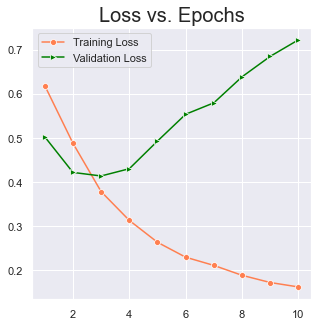

11/11 [==============================] - 0s 3ms/step - loss: 0.4135 - accuracy: 0.8500
Testing Accuracy:  85.00000238418579

Train dataset shape: (8159, 16807), 
Test dataset shape: (340, 16807)

Features Train dataset shape: (8159, 15000), 
FeaturesTest dataset shape: (340, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.70294, saving model to models\binary_classfiier\dl\merged_descr\model_15.h5

Epoch 00002: val_accuracy improved from 0.70294 to 0.82941, saving model to models\binary_classfiier\dl\merged_descr\model_15.h5

Epoch 00003: val_accuracy improved from 0.82941 to 0.84118, saving model to models\binary_classfiier\dl\merged_descr\model_15.h5

Epoch 00004: val_accuracy did not improve from 0.84118

Epoch 00005: val_accuracy did not improve from 0.84118

Epoch 00006: val_accuracy did not improve from 0.84118

Epoch 00007: val_accuracy did not improve from 0.84118

Epoch 00008: val_accuracy did not improve from 0.84118

Epoch 00009: val_accuracy did not improve from 0.

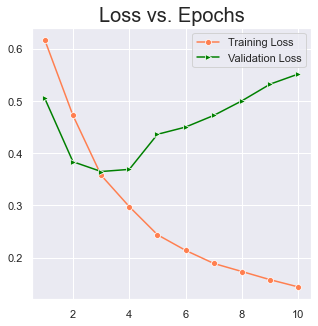

11/11 [==============================] - 0s 3ms/step - loss: 0.3648 - accuracy: 0.8412
Testing Accuracy:  84.1176450252533

Train dataset shape: (8159, 16839), 
Test dataset shape: (340, 16839)

Features Train dataset shape: (8159, 15000), 
FeaturesTest dataset shape: (340, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.71765, saving model to models\binary_classfiier\dl\merged_descr\model_16.h5

Epoch 00002: val_accuracy improved from 0.71765 to 0.85588, saving model to models\binary_classfiier\dl\merged_descr\model_16.h5

Epoch 00003: val_accuracy improved from 0.85588 to 0.87059, saving model to models\binary_classfiier\dl\merged_descr\model_16.h5

Epoch 00004: val_accuracy did not improve from 0.87059

Epoch 00005: val_accuracy did not improve from 0.87059

Epoch 00006: val_accuracy improved from 0.87059 to 0.87353, saving model to models\binary_classfiier\dl\merged_descr\model_16.h5

Epoch 00007: val_accuracy improved from 0.87353 to 0.87647, saving model to models\binar

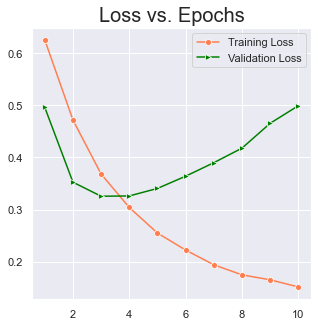

11/11 [==============================] - 0s 3ms/step - loss: 0.3898 - accuracy: 0.8765
Testing Accuracy:  87.64705657958984

Train dataset shape: (8159, 16821), 
Test dataset shape: (340, 16821)

Features Train dataset shape: (8159, 15000), 
FeaturesTest dataset shape: (340, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.70294, saving model to models\binary_classfiier\dl\merged_descr\model_17.h5

Epoch 00002: val_accuracy improved from 0.70294 to 0.80000, saving model to models\binary_classfiier\dl\merged_descr\model_17.h5

Epoch 00003: val_accuracy improved from 0.80000 to 0.81765, saving model to models\binary_classfiier\dl\merged_descr\model_17.h5

Epoch 00004: val_accuracy improved from 0.81765 to 0.82941, saving model to models\binary_classfiier\dl\merged_descr\model_17.h5

Epoch 00005: val_accuracy did not improve from 0.82941

Epoch 00006: val_accuracy did not improve from 0.82941

Epoch 00007: val_accuracy did not improve from 0.82941

Epoch 00008: val_accuracy did n

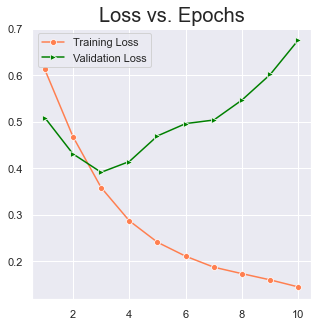

11/11 [==============================] - 0s 3ms/step - loss: 0.4144 - accuracy: 0.8294
Testing Accuracy:  82.94117450714111

Train dataset shape: (8159, 16920), 
Test dataset shape: (340, 16920)

Features Train dataset shape: (8159, 15000), 
FeaturesTest dataset shape: (340, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.70294, saving model to models\binary_classfiier\dl\merged_descr\model_18.h5

Epoch 00002: val_accuracy improved from 0.70294 to 0.78824, saving model to models\binary_classfiier\dl\merged_descr\model_18.h5

Epoch 00003: val_accuracy improved from 0.78824 to 0.81176, saving model to models\binary_classfiier\dl\merged_descr\model_18.h5

Epoch 00004: val_accuracy did not improve from 0.81176

Epoch 00005: val_accuracy did not improve from 0.81176

Epoch 00006: val_accuracy did not improve from 0.81176

Epoch 00007: val_accuracy did not improve from 0.81176

Epoch 00008: val_accuracy did not improve from 0.81176

Epoch 00009: val_accuracy did not improve from 0.

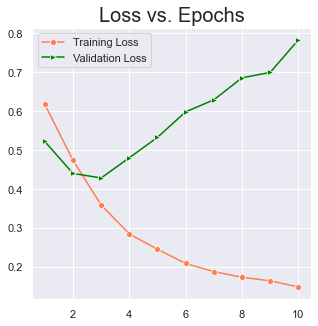

11/11 [==============================] - 0s 3ms/step - loss: 0.4281 - accuracy: 0.8118
Testing Accuracy:  81.17647171020508

Train dataset shape: (8159, 16912), 
Test dataset shape: (340, 16912)

Features Train dataset shape: (8159, 15000), 
FeaturesTest dataset shape: (340, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.70294, saving model to models\binary_classfiier\dl\merged_descr\model_19.h5

Epoch 00002: val_accuracy improved from 0.70294 to 0.81176, saving model to models\binary_classfiier\dl\merged_descr\model_19.h5

Epoch 00003: val_accuracy did not improve from 0.81176

Epoch 00004: val_accuracy improved from 0.81176 to 0.81765, saving model to models\binary_classfiier\dl\merged_descr\model_19.h5

Epoch 00005: val_accuracy did not improve from 0.81765

Epoch 00006: val_accuracy did not improve from 0.81765

Epoch 00007: val_accuracy did not improve from 0.81765

Epoch 00008: val_accuracy did not improve from 0.81765

Epoch 00009: val_accuracy did not improve from 0.

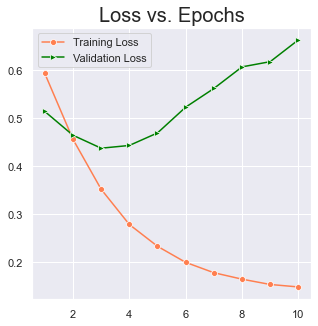

11/11 [==============================] - 0s 3ms/step - loss: 0.4436 - accuracy: 0.8176
Testing Accuracy:  81.76470398902893

Train dataset shape: (8159, 16890), 
Test dataset shape: (340, 16890)

Features Train dataset shape: (8159, 15000), 
FeaturesTest dataset shape: (340, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.70294, saving model to models\binary_classfiier\dl\merged_descr\model_20.h5

Epoch 00002: val_accuracy improved from 0.70294 to 0.83235, saving model to models\binary_classfiier\dl\merged_descr\model_20.h5

Epoch 00003: val_accuracy improved from 0.83235 to 0.84412, saving model to models\binary_classfiier\dl\merged_descr\model_20.h5

Epoch 00004: val_accuracy did not improve from 0.84412

Epoch 00005: val_accuracy did not improve from 0.84412

Epoch 00006: val_accuracy did not improve from 0.84412

Epoch 00007: val_accuracy did not improve from 0.84412

Epoch 00008: val_accuracy did not improve from 0.84412

Epoch 00009: val_accuracy did not improve from 0.

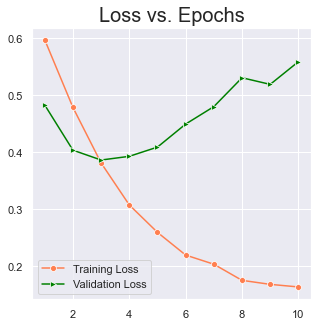

11/11 [==============================] - 0s 3ms/step - loss: 0.3864 - accuracy: 0.8441
Testing Accuracy:  84.41176414489746

Train dataset shape: (8159, 16825), 
Test dataset shape: (340, 16825)

Features Train dataset shape: (8159, 15000), 
FeaturesTest dataset shape: (340, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.70294, saving model to models\binary_classfiier\dl\merged_descr\model_21.h5

Epoch 00002: val_accuracy improved from 0.70294 to 0.81176, saving model to models\binary_classfiier\dl\merged_descr\model_21.h5

Epoch 00003: val_accuracy improved from 0.81176 to 0.81471, saving model to models\binary_classfiier\dl\merged_descr\model_21.h5

Epoch 00004: val_accuracy improved from 0.81471 to 0.82647, saving model to models\binary_classfiier\dl\merged_descr\model_21.h5

Epoch 00005: val_accuracy did not improve from 0.82647

Epoch 00006: val_accuracy improved from 0.82647 to 0.83529, saving model to models\binary_classfiier\dl\merged_descr\model_21.h5

Epoch 00007: 

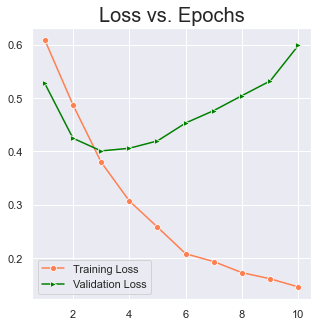

11/11 [==============================] - 0s 3ms/step - loss: 0.4532 - accuracy: 0.8353
Testing Accuracy:  83.52941274642944

Train dataset shape: (8159, 16511), 
Test dataset shape: (340, 16511)

Features Train dataset shape: (8159, 15000), 
FeaturesTest dataset shape: (340, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.70294, saving model to models\binary_classfiier\dl\merged_descr\model_22.h5

Epoch 00002: val_accuracy did not improve from 0.70294

Epoch 00003: val_accuracy improved from 0.70294 to 0.80294, saving model to models\binary_classfiier\dl\merged_descr\model_22.h5

Epoch 00004: val_accuracy did not improve from 0.80294

Epoch 00005: val_accuracy did not improve from 0.80294

Epoch 00006: val_accuracy did not improve from 0.80294

Epoch 00007: val_accuracy did not improve from 0.80294

Epoch 00008: val_accuracy did not improve from 0.80294

Epoch 00009: val_accuracy did not improve from 0.80294


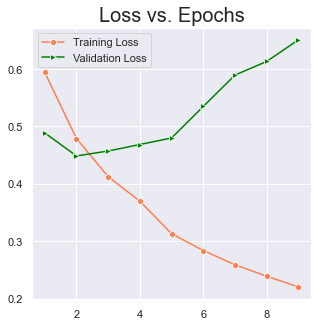

11/11 [==============================] - 0s 3ms/step - loss: 0.4571 - accuracy: 0.8029
Testing Accuracy:  80.29412031173706

Train dataset shape: (8159, 16929), 
Test dataset shape: (340, 16929)

Features Train dataset shape: (8159, 15000), 
FeaturesTest dataset shape: (340, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.70294, saving model to models\binary_classfiier\dl\merged_descr\model_23.h5

Epoch 00002: val_accuracy improved from 0.70294 to 0.81471, saving model to models\binary_classfiier\dl\merged_descr\model_23.h5

Epoch 00003: val_accuracy improved from 0.81471 to 0.83235, saving model to models\binary_classfiier\dl\merged_descr\model_23.h5

Epoch 00004: val_accuracy did not improve from 0.83235

Epoch 00005: val_accuracy did not improve from 0.83235

Epoch 00006: val_accuracy did not improve from 0.83235

Epoch 00007: val_accuracy improved from 0.83235 to 0.83529, saving model to models\binary_classfiier\dl\merged_descr\model_23.h5

Epoch 00008: val_accuracy impro

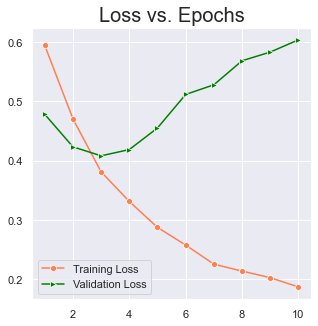

11/11 [==============================] - 0s 3ms/step - loss: 0.5682 - accuracy: 0.8412
Testing Accuracy:  84.1176450252533

Train dataset shape: (8159, 15718), 
Test dataset shape: (340, 15718)

Features Train dataset shape: (8159, 15000), 
FeaturesTest dataset shape: (340, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.70294, saving model to models\binary_classfiier\dl\merged_descr\model_24.h5

Epoch 00002: val_accuracy improved from 0.70294 to 0.79706, saving model to models\binary_classfiier\dl\merged_descr\model_24.h5

Epoch 00003: val_accuracy improved from 0.79706 to 0.81176, saving model to models\binary_classfiier\dl\merged_descr\model_24.h5

Epoch 00004: val_accuracy improved from 0.81176 to 0.81765, saving model to models\binary_classfiier\dl\merged_descr\model_24.h5

Epoch 00005: val_accuracy did not improve from 0.81765

Epoch 00006: val_accuracy improved from 0.81765 to 0.82353, saving model to models\binary_classfiier\dl\merged_descr\model_24.h5

Epoch 00007: v

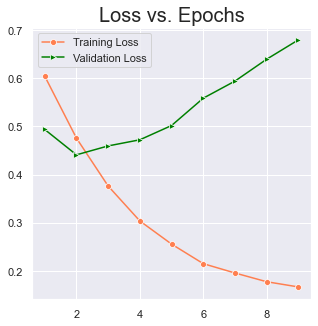

11/11 [==============================] - 0s 3ms/step - loss: 0.6795 - accuracy: 0.8265
Testing Accuracy:  82.64706134796143

Train dataset shape: (8160, 16731), 
Test dataset shape: (339, 16731)

Features Train dataset shape: (8160, 15000), 
FeaturesTest dataset shape: (339, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.70501, saving model to models\binary_classfiier\dl\merged_descr\model_25.h5

Epoch 00002: val_accuracy improved from 0.70501 to 0.80531, saving model to models\binary_classfiier\dl\merged_descr\model_25.h5

Epoch 00003: val_accuracy improved from 0.80531 to 0.82596, saving model to models\binary_classfiier\dl\merged_descr\model_25.h5

Epoch 00004: val_accuracy improved from 0.82596 to 0.83186, saving model to models\binary_classfiier\dl\merged_descr\model_25.h5

Epoch 00005: val_accuracy did not improve from 0.83186

Epoch 00006: val_accuracy did not improve from 0.83186

Epoch 00007: val_accuracy did not improve from 0.83186

Epoch 00008: val_accuracy did n

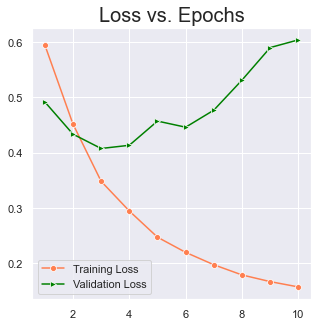

11/11 [==============================] - 0s 3ms/step - loss: 0.5899 - accuracy: 0.8348
Testing Accuracy:  83.48082304000854


In [69]:
from pathlib import Path
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_extraction.text import TfidfVectorizer


def get_model_name(k):
    return f'model_{k}.h5'

NUM_SPLITS = 25
EPOCHS = 15
save_dir = Path('./models/binary_classfiier/dl/merged_descr')
fold_var = 1
NGRAM_RANGE = (1, 2)
TOP_K = 15000
TOKEN_MODE = 'word'
MIN_DOC_FREQ = 2
NUM_CLASSES = 2

kwargs = {
        'ngram_range' : NGRAM_RANGE,
        'dtype' : 'int32',
        'strip_accents' : 'unicode',
        'decode_error' : 'replace',
        'analyzer' : TOKEN_MODE,
        'min_df' : MIN_DOC_FREQ
    }

val_accs = []
skf = StratifiedKFold(n_splits=NUM_SPLITS, shuffle=False, random_state=seed)

for train_indices, test_indices in skf.split(X, y):
    X_train_split, X_test_split = X[train_indices], X[test_indices]
    y_train_split, y_test_split = y[train_indices], y[test_indices]
    vectorizer = TfidfVectorizer(**kwargs)
    X_train_vec = vectorizer.fit_transform(X_train_split)
    X_test_vec = vectorizer.transform(X_test_split)
    print(f"\nTrain dataset shape: {X_train_vec.shape}, \nTest dataset shape: {X_test_vec.shape}")

    selector = SelectKBest(f_classif, k=min(TOP_K, X_train_vec.shape[1]))
    selector.fit(X_train_vec, y_train_split)
    X_train_vec = selector.transform(X_train_vec).astype('float32')
    X_test_vec = selector.transform(X_test_vec).astype('float32')
    X_train_vec = X_train_vec.toarray()
    X_test_vec = X_test_vec.toarray()

    print(f"\nFeatures Train dataset shape: {X_train_vec.shape}, \nFeaturesTest dataset shape: {X_test_vec.shape}")
    model_ = None
    model_ = Sequential([   
        Dense(30, activation='relu', input_shape=X_train_vec.shape[1:]),
        Dropout(0.5),
        Dense(20, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model_.compile(
        loss = 'binary_crossentropy',
        optimizer = 'adam',
        metrics = ['accuracy']
    )
    
    checkpoint = tensorflow.keras.callbacks.ModelCheckpoint(save_dir / get_model_name(fold_var),
                                                            monitor='val_accuracy',
                                                            verbose=1,
                                                            save_best_only=True,
                                                            mode='max')

    h_ = model_.fit(
            X_train_vec, y_train_split,
            validation_data = (X_test_vec, y_test_split),  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [checkpoint, early_stop],
            verbose = False)
    
    model_.load_weights(save_dir / get_model_name(fold_var))
    plot_learning_curve(h_)
    loss, acc = model_.evaluate(X_test_vec, y_test_split)
    print("Testing Accuracy: ", acc*100)
    val_accs.append(acc)
    tensorflow.keras.backend.clear_session()
    fold_var += 1

In [70]:
print("Testing Accuracy: ", np.mean(val_accs)*100)   # average k fold accuracy

Testing Accuracy:  83.59805631637573


<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Metrics: </span></strong></li>
</ul></h3>

<table style="width:100%">
  <tr>
    <th>Model</th>
    <th>Test Accuracy</th>
  </tr>
  <tr>
    <td>Simple Feed-Forward Net using Embedding Layer</td>
    <td>81.88%</td>
  </tr>
<tr>
    <td>Feed-Forward NN + Batch Norm</td>
    <td>75.22%</td>
  </tr>
<tr>
    <td>Feed-Forward NN + Dropout</td>
    <td>80.94%</td>
  </tr>
    <tr>
    <td>Feed-Forward NN + Pre-trained GloVe embeddings</td>
    <td>78.04%</td>
  </tr>
  <tr>
    <td>LSTM</td>
    <td>72.71%</td>
  </tr>
    
  <tr>
    <td>Bi-Directional LSTM</td>
    <td>81.18%</td>
  </tr>
<tr>
    <td>Convolution Blocks (Dimensionality Reduction) + LSTM</td>
    <td>80.86%</td>
  </tr>
    <tr>
    <td>Convolution Blocks (Dimensionality Reduction) + Bi-LSTM</td>
    <td>82.67%</td>
  </tr>
<tr>
    <td>TfIdf Vectors + Feature Selection + Feed-forward Neural Net</td>
    <td>82.98%</td>
  </tr>
<tr>
    <td>Stratified KFold Validation + TfIdf Vectors + Feature Selection + +Feed-forward Neural Net</td>
    <td>83.60%</td>
  </tr>
</table>